In [1]:
# import necessary packages 
import numpy as np
from IPython.display import display
from pathlib import Path
import datetime as dt 
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import preprocessing
from scipy.io import loadmat
import scipy.spatial.distance as dist

mat = loadmat('spamData.mat')  # load mat-file, make sure the mat-file is under the same directory as the python notebook file
# mat = loadmat('../input/spamdata/spamData.mat')
# sorted(mat.keys())
x_test = mat['Xtest']  # features of emails in test set
x_train = mat['Xtrain']  # features of emails in training set
y_test = mat['ytest']  # categories of emails in test set
y_train = mat['ytrain']  # categories of emails in training set

In [2]:
# data preprocessing: binarization and log transformation

def logTrans(data):
# this function performs log transformation on the features
    return np.log(data + 0.1)

# binarize x_train and x_test
xtrain = preprocessing.binarize(x_train)
xtest = preprocessing.binarize(x_test)
# log transform x_train and x_test
xtest_log = logTrans(x_test)
xtrain_log = logTrans(x_train)
# convert y_train and y_test to 1-D arrays
ytrain = y_train.flatten()
ytest = y_test.flatten()

In [3]:
# let N1 be number of spam emails, N0 be number of non-spammed emails, N be total # of emails

N1train = 0
Ntrain = len(ytrain)
N1train = np.sum(ytrain[ytrain == 1])
N0train = Ntrain - N1train
print (N1train, Ntrain, N1train/Ntrain)

# computation of maximum likelihood estimation MLE and log of MLE
MLE = N1train / Ntrain
MLE_neg = 1 - MLE
MLE_log = np.log(MLE)
MLE_neg_log = np.log(MLE_neg)

# # feature likelihood from training data
# feature_likelihood = np.mean(xtrain[ytrain == 1], axis = 0)
# print (feature_likelihood)

1240 3065 0.40456769983686786


## Q1. Beta-binomial Naive Bayes 

In [4]:
# define functions used for beta-binomial naive bayes

def sum_x_train(spammed):
# this function computes the number of appearance of each binarized features in the training set
# the input spammed is either 0 or 1
    return np.sum(xtrain[ytrain == spammed], axis = 0).astype('uint16')
def sum_y_train(spammed):
# this function returns the total number of spammed/non-spammed emails in the training set
    return len(ytrain[ytrain == spammed])
def posterior_predictive_distribution (spammed, alpha):
# this function computes the posterior predictive distribution for a given alpha
    return ((sum_x_train(spammed)+alpha)/(sum_y_train(spammed)+2*alpha))
def classify(email, alpha):
# this function classifies an input email as either spammed or non-spammed with posterior predictive distribution for a given alpha
    feature_count = len(email)
    
    param_spam = 1
    param_non_spam = 1
    
    temp_post_dist_0 = posterior_predictive_distribution(0, alpha)
    temp_post_dist_1 = posterior_predictive_distribution(1, alpha)
    
    for i in np.arange(feature_count):
#         param_spam += (email[i] == 1) * np.log(temp_post_dist_1) + \
#         (email[i] == 0) * np.log(1-temp_post_dist_1)
#         param_non_spam += (email[i] == 1) * np.log(temp_post_dist_0) + \
#         (email[i] == 0) * np.log(1-temp_post_dist_0)
        
#     prob_spam = MLE_log + param_spam
#     prob_non_spam = MLE_neg_log + param_non_spam

#         param_spam = param_spam * (temp_post_dist_1 ** (email[i] == 1)) * ((1-temp_post_dist_1) ** (email[i] == 0))
#         param_non_spam = param_non_spam * (temp_post_dist_0 ** (email[i] == 1)) * ((1-temp_post_dist_0) ** (email[i] == 0))
        if (email[i] == 1):
            param_spam = param_spam * temp_post_dist_1[i]
            param_non_spam = param_non_spam * temp_post_dist_0[i]
        if (email[i] == 0):
            param_spam = param_spam * (1 - temp_post_dist_1[i])
            param_non_spam = param_non_spam * (1 - temp_post_dist_0[i])
        
    # computes the probabilities of email being spammed or non-spammed
    prob_spam = MLE * param_spam
    prob_non_spam = MLE_neg * param_non_spam

    # returns 1 if the email is classified as spammed (probability of the email being classified as spammed is higher than non-spammed)
    # returns 0 if the email is classified as non-spammed
    return (prob_spam > prob_non_spam).astype('uint8')

def calc_error_rate_test_beta(alpha):
    # this function calculates the error rate of test set for beta-binomial model
    error_count = 0
    for count, email in enumerate(xtest):
        if (classify(email, alpha) != ytest[count]):
            error_count += 1
    return error_count/len(xtest) * 100

def calc_error_rate_train_beta(alpha):
    # this function calculates the error rate of training set for beta-binomial model
    error_count = 0
    for count, email in enumerate(xtrain):
        if (classify(email, alpha) != ytrain[count]):
            error_count += 1
    return error_count/len(xtrain) * 100

In [5]:
# compute error rate for test data with different alpha values
alphas = np.arange(0,100.5,0.5)
beta_error_rate_test = []
beta_error_rate_train = []

# computes error rates for test set and training set
for alpha in alphas:
    beta_error_rate_test.append(calc_error_rate_test_beta(alpha))

for alpha in alphas:
    beta_error_rate_train.append(calc_error_rate_train_beta(alpha))

### Plots of training and test error rates versus alpha

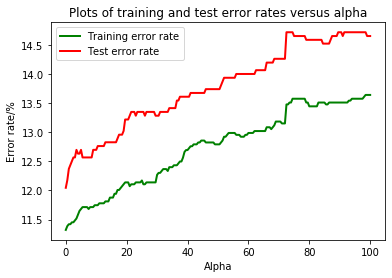

In [6]:
plt.plot(alphas,beta_error_rate_train,'g',label='Training error rate', linewidth=2)
plt.plot(alphas,beta_error_rate_test,'r',label='Test error rate', linewidth=2)
plt.title('Plots of training and test error rates versus alpha')
plt.ylabel('Error rate/%')
plt.xlabel('Alpha')
plt.legend()
plt.show()

### Observations of training and test error rates as alpha changes:

Both training and test error rates increases as alpha increases from 0 to 100. Training error rates are generally lower than test error rates as the model is trained with the training set

### Training and test error rates for alpha = 1, 10, 100

In [7]:
# print ("Training error rate for alpha = 1:", calc_error_rate_train_beta(1), "%")
# print ("Training error rate for alpha = 10:", calc_error_rate_train_beta(10), "%")
# print ("Training error rate for alpha = 100:", calc_error_rate_train_beta(100), "%")
# print ("Test error rate for alpha = 1:", calc_error_rate_test_beta(1), "%")
# print ("Test error rate for alpha = 10:", calc_error_rate_test_beta(10), "%")
# print ("Test error rate for alpha = 100:", calc_error_rate_test_beta(100), "%")

for idx, alpha in enumerate(alphas):
    if (alpha == 1 or alpha == 10 or alpha == 100):
        print ("Training error rate for alpha =", alpha, ":", beta_error_rate_train[idx], "%")
        print ("Test error rate for alpha =", alpha, ":", beta_error_rate_test[idx], "%")

Training error rate for alpha = 1.0 : 11.419249592169658 %
Test error rate for alpha = 1.0 : 12.369791666666668 %
Training error rate for alpha = 10.0 : 11.745513866231647 %
Test error rate for alpha = 10.0 : 12.6953125 %
Training error rate for alpha = 100.0 : 13.637846655791192 %
Test error rate for alpha = 100.0 : 14.6484375 %


## Q2. Gaussian Naive Bayes

In [8]:
# compute mean and standard deviation for ML estimation
xtrain_log_mean_spam = np.mean(xtrain_log[ytrain == 1], axis = 0)
xtrain_log_std_spam = np.std(xtrain_log[ytrain == 1], axis = 0)
xtrain_log_mean_nonspam = np.mean(xtrain_log[ytrain == 0], axis = 0)
xtrain_log_std_nonspam = np.std(xtrain_log[ytrain == 0], axis = 0)

In [9]:
def classify_gaussian(email):
# This function classifies the input email as either spammed or non-spammed with Gaussian Naive Bayes
    feature_count = len(email)
    
    param_spam = 0
    param_non_spam = 0
    
    for i in np.arange(feature_count):
        param_spam += -np.log(xtrain_log_std_spam[i]) - ((email[i] - xtrain_log_mean_spam[i])/(xtrain_log_std_spam[i])) ** 2 / 2
        param_non_spam += -np.log(xtrain_log_std_nonspam[i]) - ((email[i] - xtrain_log_mean_nonspam[i])/(xtrain_log_std_nonspam[i])) ** 2 / 2
        
    prob_spam = MLE + param_spam
    prob_non_spam = MLE_neg + param_non_spam
    
    return (prob_spam > prob_non_spam).astype('uint8')

def error_rate_gaussian(data, result):
# This function computes the error rates for a given set of emails 
    error_count = 0
    
    for count, email in enumerate(data):
        if (classify_gaussian(email) != result[count]):
            error_count += 1
    return (error_count / len(data)) * 100

### Training and test error rates for log-transformed data

In [10]:
gaussian_error_rate_train = error_rate_gaussian(xtrain_log, ytrain)
gaussian_error_rate_test = error_rate_gaussian(xtest_log, ytest)
print ("Training error rate:", gaussian_error_rate_train, "%")
print ("Test error rate:", gaussian_error_rate_test, "%")

Training error rate: 16.867862969004893 %
Test error rate: 16.341145833333336 %


## Q3. Logistic Regression 

In [11]:
# lambda = [1.2,...,10,15,20,...,95,100]
lambdas = np.hstack((np.arange(1,10,1), np.arange(10,105,5)))

In [12]:
def sigmoid(x):
# This function returns the sigmoid of the input
    return 1/(1+np.exp(-x))

def calc_parameters(x_data, y_data, omega, lam):
# This function computes regularized NLL, g and H with given omega and lambda values
    feature_count = x_data.shape[1]
    x_data = np.insert(x_data, 0, 1, axis = 1)
    I = np.diag(np.insert(np.ones(feature_count), 0, 0))
    NLL = 0
    
    mus = sigmoid(np.dot(x_data, omega)) # an array of mu for each individual email in x_train
    s_param = []
    
    for y, mu in zip(y_data, mus):
        NLL -= y * np.log(mu) + (1 - y) * np.log(1 - mu)
        s_param.append(mu * (1 - mu))
    g = np.dot(x_data.T, (mus - y_data))
    S = np.diag(s_param)
    H = np.dot(x_data.T, np.dot(S, x_data))
    
    # regularization of parameters， the bias term is omitted in the regularization process
    NLL_reg = NLL + 0.5 * lam * np.inner(omega[1:], omega[1:])
    g_reg = g + np.insert(lam * omega[1:], 0, 0)
    H_reg = H + np.dot(lam, I)
    
    return NLL_reg, g_reg, H_reg

def calc_omega(x_data, y_data, lam):
# This function finds the omega by implementing Newton's method

    feature_count = x_data.shape[1]
    Init = np.zeros(feature_count + 1)
    omega = Init
    convergence = False
    iter_count = 0
    
    # iterates to find optimal omega
    while convergence == False:
        NLL, g, H = calc_parameters(x_data, y_data, omega, lam)
        iter_count += 1
        omega_new = omega - np.dot(np.linalg.inv(H), g)
        error = np.inner(omega_new - omega, omega_new - omega)/np.inner(omega, omega)
        if error < 0.001:
            convergence = True
        else:
            omega = omega_new
    return omega_new
        

def calc_error_rate_logReg(x_data, y_data, x_train, y_train, lam):
# This function calculates the error rates for given set of emails with logistic regression model
    omega = calc_omega(x_train, y_train, lam)
    error_count = 0
    classified = sigmoid(omega[0] + np.dot(x_data, omega[1:])) > 0.5
    for idx, item in enumerate(classified):
        if (item != y_data[idx]):
            error_count += 1
    return (error_count / len(y_data)) * 100

In [13]:
logReg_error_rate_train = []

for lam in lambdas:
    logReg_error_rate_train.append(calc_error_rate_logReg(xtrain_log, ytrain, xtrain_log, ytrain, lam))

logReg_error_rate_test = []

for lam in lambdas:
    logReg_error_rate_test.append(calc_error_rate_logReg(xtest_log, ytest, xtrain_log, ytrain, lam))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


### Plots of training and test error rates versus lambda

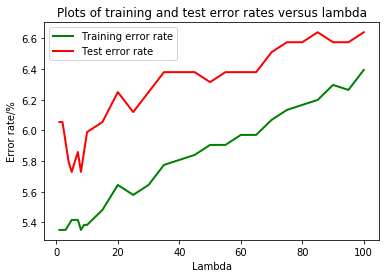

In [14]:
plt.plot(lambdas,logReg_error_rate_train,'g',label='Training error rate', linewidth=2)
plt.plot(lambdas,logReg_error_rate_test,'r',label='Test error rate', linewidth=2)
plt.title('Plots of training and test error rates versus lambda')
plt.ylabel('Error rate/%')
plt.xlabel('Lambda')
plt.legend()
plt.show()

### Observations about training and test errors as lambda changes

In general, training and test errors increase as lambda increases. When lambda is between 4 and 8, test error rate is significantly lower compared to other lambda values, which means at these lambda values, the model is more accurate.

## Training and test error rates for lambda = 1, 10, 100

In [15]:
for idx, lam in enumerate(lambdas):
    if (lam == 1 or lam == 10 or lam == 100):
        print ("Training error rate for lambda =", lam, ":", logReg_error_rate_train[idx], "%")
        print ("Test error rate for lambda =", lam, ":", logReg_error_rate_test[idx], "%")

Training error rate for lambda = 1 : 5.35073409461664 %
Test error rate for lambda = 1 : 6.0546875 %
Training error rate for lambda = 10 : 5.383360522022838 %
Test error rate for lambda = 10 : 5.989583333333334 %
Training error rate for lambda = 100 : 6.394779771615008 %
Test error rate for lambda = 100 : 6.640625 %


## K-Nearest Neighbors

In [16]:
# K = [1,2,...,9,10,15,...,95,100]
Ks = np.hstack((np.arange(1,10,1), np.arange(10,105,5)))

In [17]:
def calc_Euclidean_distance (data_1, data_2):
# This function computes the Eculidean distance for 2 sets of data
# The computation makes use of function from scipy package
    Euc_dist = np.array([[dist.euclidean(data_1[idx1], data_2[idx2]) for idx2 in np.arange(len(data_2))] for idx1 in np.arange(len(data_1))])
    return Euc_dist

def knn_error_rate(distance, y_data, y_train, K):
# This function computes the error rate by using K-nearest neighbor 
    error_count = 0
    for idx, distance_1D in enumerate(distance):
        dist_idx = np.argsort(distance_1D)[:K]
        spammed = (np.sum(y_train[dist_idx] == 1))
        non_spammed = (np.sum(y_train[dist_idx] == 0))
        if ((spammed > non_spammed) != y_data[idx]):
            error_count += 1
    return (error_count / len(y_data)) * 100
            

In [18]:
# computes euclidean distances for training set and test set
euc_dist_train = calc_Euclidean_distance(xtrain_log, xtrain_log)
euc_dist_test = calc_Euclidean_distance(xtest, xtrain)

knn_error_rate_test = []
knn_error_rate_train = []

# computes error rates for training set and test set
for k in Ks:
    knn_error_rate_test.append(knn_error_rate(euc_dist_test, ytest, ytrain, k))
    knn_error_rate_train.append(knn_error_rate(euc_dist_train, ytrain, ytrain, k))

### Plots of training and test error rates versus K

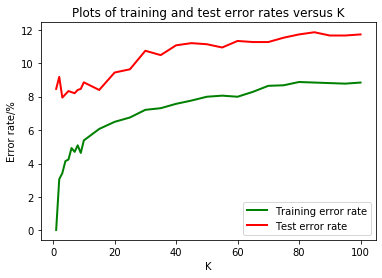

In [19]:
plt.plot(Ks,knn_error_rate_train,'g',label='Training error rate', linewidth=2)
plt.plot(Ks,knn_error_rate_test,'r',label='Test error rate', linewidth=2)
plt.title('Plots of training and test error rates versus K')
plt.ylabel('Error rate/%')
plt.xlabel('K')
plt.legend()
plt.show()

### Observation about training and test errors as K changes

When K is small (K < 20), training errors increases at a very fast rate as K increases; when K is large, training errors increases slightly as K increases. For test errors, the values are relatively stable, and the only major change is when K is approximately 20. This possibly means that when K is very small or very large, a slight change in K does not affect how the model classifies the data. In addition, when K = 1, the training error is extremely small (0.032%), but the test error is still high at 8.46%. This implies over-fitting.

### Training and testing error rates for K = 1, 10 and 100

In [20]:
for idx, k in enumerate(Ks):
    if (k == 1 or k == 10 or k == 100):
        print ("Training error rate for K =", k, ":", knn_error_rate_train[idx], "%")
        print ("Test error rate for K =", k, ":", knn_error_rate_test[idx], "%")

Training error rate for K = 1 : 0.03262642740619902 %
Test error rate for K = 1 : 8.463541666666668 %
Training error rate for K = 10 : 5.383360522022838 %
Test error rate for K = 10 : 8.854166666666668 %
Training error rate for K = 100 : 8.841761827079935 %
Test error rate for K = 100 : 11.71875 %


## Q5. Survey

Time spent on the assignment is approximately 40 hours.
The assignment facilitates the understanding of lecture materials. It would be beneficial if the models can be used to compute the data with different preprocessing and observe the difference (although the coding process is likely to be repetitive).